In [1]:
from pymoo.algorithms.moo.dnsga2 import DNSGA2
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.callback import CallbackCollection, Callback
from pymoo.core.problem import ElementwiseProblem, Problem
from pymoo.core.duplicate import ElementwiseDuplicateElimination
from pymoo.problems.functional import FunctionalProblem, func_return_none
from pymoo.optimize import minimize
from pymoo.problems.dyn import TimeSimulation
from pymoo.problems.dynamic.df import DF1
from pymoo.problems.multi import CTP3
from pymoo.problems.multi.srn import SRN
import matplotlib.pyplot as plt

import zuko
from zuko.flows import GMM
import numpy as np
import torch

from ikflow.utils import set_seed
from ikflow.model_loading import get_ik_solver

from utils.settings import config
from utils.utils import *
from utils.model import *
from utils.robot import Robot

config.py: Using device 'cuda:0'


In [67]:
set_seed()
num_trails = 100
num_solutions = 500
# Build IKFlowSolver and set weights
ik_solver, hyper_parameters = get_ik_solver("panda__full__lp191_5.25m")
robot = ik_solver.robot
panda = Robot(verbose=False)

set_seed() - random int:  44
ndim_tot=7
dim_cond=8
WorldModel::LoadRobot: /tmp/panda_arm_hand_formatted_link_filepaths_absolute.urdf
joint mimic: no multiplier, using default value of 1 
joint mimic: no offset, using default value of 0 
URDFParser: Link size: 17
URDFParser: Joint size: 12
URDFParser: Done loading robot file /tmp/panda_arm_hand_formatted_link_filepaths_absolute.urdf


In [68]:
traj_dir = sample_ee_traj(robot=panda, load_time='')
ee_traj = load_numpy(file_path=traj_dir + 'ee_traj.npy')
q_traj = load_numpy(file_path=traj_dir + 'q_traj.npy')
quaternions = np.zeros((len(ee_traj), 4))
quaternions[:, 0] = np.random.randn() * 2e-2 + 1
target_poses = np.column_stack((ee_traj, quaternions))

100%|██████████| 20/20 [00:00<00:00, 2815.25it/s]

mkdir /home/luca/ikpflow/data/panda/trajectory/06051439
/home/luca/ikpflow/data/panda/trajectory/06051439/ load successfully.


In [69]:
# -> unrefined solutions
solutions, l2_errors, angular_errors, joint_limits_exceeded, self_colliding, runtime = ik_solver.solve_n_poses(
    target_poses, refine_solutions=False, return_detailed=True
)
print(
    "\nGot {} ikflow solutions in {} ms. The L2 error of the solutions = {} (cm)".format(
        target_poses.shape[0], round(runtime * 1000, 3), l2_errors * 100
    )
)

iksols = solutions.detach().cpu().numpy()
df = qtraj_evaluation(robot=panda, qs=iksols, l2_errs=l2_errors)
df.describe()


Got 20 ikflow solutions in 71.163 ms. The L2 error of the solutions = [0.50937857 0.6214635  0.8365316  0.3228696  0.58900451 0.6682579
 0.86637628 0.87098363 0.75949735 0.69372938 0.74468509 0.64547827
 0.68793617 0.64965479 5.44397224 6.47440326 8.8910089  8.57179194
 8.70668805 3.98766742] (cm)


,l2_err,ang_errs(sum)
count,20.000000,20.000000
mean,0.025771,557.138124
std,0.031593,186.120470
min,0.003229,150.073578
25%,0.006486,499.240189
50%,0.007521,600.077972
75%,0.043517,686.779160
max,0.088910,752.922791


In [70]:
iksols = np.zeros((len(target_poses), num_solutions, panda.dof))

# -> Get some refined solutions
for i, target_pose in enumerate(target_poses):
    solutions, l2_errors, angular_errors, joint_limits_exceeded, self_colliding, runtime = ik_solver.solve(
        target_pose, num_solutions, refine_solutions=False, return_detailed=True
    )
    iksols[i] = solutions.detach().cpu().numpy()
    
    # print(
    #     "\nGot {} ikflow solutions in {} ms. Solution L2 errors = {} (cm)".format(
    #         num_solutions, round(runtime * 1000, 3), l2_errors * 100
    #     )
    # )

In [56]:
class ProblemWrapper(ElementwiseProblem):
    
    def __init__(self, 
                 iksols,
                 target_poses,
                 **kwargs):
        self.target_poses = target_poses
        self.all_sols = iksols
        self.all_l2_errs = self.calc_all_l2_errs()
        xl = np.zeros((iksols.shape[0]))
        xu = np.full_like(xl, fill_value=len(iksols)-1)
        super().__init__(n_var=len(xl),
                         n_obj=1,
                         n_ieq_constr=0,
                         n_eq_constr=0,
                         xl=xl,
                         xu=xu,
                         **kwargs)
    
    def calc_all_l2_errs(self):
        all_l2_errs = np.ones((self.all_sols.shape[0], self.all_sols.shape[1]))
        for i in range(self.all_sols.shape[1]):
            qtraj = self.all_sols[:, i, :]
            l2_errs, _, _, _ = evaluate_solutions(
                ik_solver.robot, 
                torch.tensor(self.target_poses), 
                torch.tensor(qtraj))
            all_l2_errs[:, i] = l2_errs
        return all_l2_errs
    
    def ang_jump(self, qs):
        errs = calc_ang_errs(qs)
        return errs.mean()
    
    def pheno(self, design):
        return np.floor(design).astype(int)
        
    def iksols(self, pheno):
        qs = np.zeros((self.all_sols.shape[0], self.all_sols.shape[2]))
        for ri, i in enumerate(pheno):
            qs[ri] = self.all_sols[ri, i]
        return qs

    def l2_errs(self, pheno):
        l2_errs = 0
        for ri, i in enumerate(pheno):
            l2_errs += self.all_l2_errs[ri, i]
        return l2_errs / len(pheno)

    def _evaluate(self, design, out, *args, **kwargs):
        pheno = self.pheno(design)
        iksols = self.iksols(pheno=pheno)
        ang_errs = self.ang_jump(qs=iksols)
        l2_errs = self.l2_errs(pheno=pheno)
        out["F"] = ang_errs / 1000 + l2_errs
        out["ang_errs"] = ang_errs
        out["l2_errs"] = l2_errs
        out["pheno"] = pheno
        out["hash"] = hash(str(pheno))

class MyElementwiseDuplicateElimination(ElementwiseDuplicateElimination):

    def is_equal(self, a, b):
        return a.get("hash") == b.get("hash")

In [57]:
from pymoo.algorithms.soo.nonconvex.brkga import BRKGA
from pymoo.optimize import minimize

problem = ProblemWrapper(
    iksols=iksols, 
    target_poses=target_poses)

algorithm = BRKGA(
    n_elites=200,
    n_offsprings=1000,
    n_mutants=300,
    # save_history=True,
    bias=0.7)

res = minimize(problem,
               algorithm,
               ("n_gen", 50),
               seed=1,
               verbose=True,
               save_history=True,
               eliminate_duplicates=MyElementwiseDuplicateElimination())

print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))
print("Solution", res.problem.iksols(res.problem.pheno(res.X)))

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |     1500 |  0.5142476159 |  0.3496692264
     2 |     2800 |  0.4856084182 |  0.3395155213
     3 |     4100 |  0.4671496769 |  0.3119015032
     4 |     5400 |  0.4505889450 |  0.2970631622
     5 |     6700 |  0.4392520217 |  0.2912987348
     6 |     8000 |  0.4260793706 |  0.2238496888
     7 |     9300 |  0.4191829622 |  0.2238496888
     8 |    10600 |  0.4078933341 |  0.2238496888
     9 |    11900 |  0.3987684261 |  0.2238496888
    10 |    13200 |  0.3895610525 |  0.2166896741
    11 |    14500 |  0.3786571301 |  0.1944959829
    12 |    15800 |  0.3706228538 |  0.1944959829
    13 |    17100 |  0.3600700808 |  0.1653384591
    14 |    18400 |  0.3533856129 |  0.1653384591
    15 |    19700 |  0.3448255549 |  0.1653384591
    16 |    21000 |  0.3415292799 |  0.1653384591
    17 |    22300 |  0.3386547716 |  0.1653384591
    18 |    23600 |  0.3284168361 |  0.1653384591
    19 |    24900 |  0.3228017047 |  0.1653384591


In [58]:
from jkinpylib.evaluation import evaluate_solutions
best_iksol = res.problem.iksols(res.problem.pheno(res.X))
l2_errs, ang_errs = res.opt.get("l2_errs", "ang_errs")
print(l2_errs, ang_errs)
panda.plot(qs=best_iksol)

[0.03104525] [103.03775747]


In [59]:
hist = res.history

n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_l2 = []             # constraint violation in each generation
hist_l2_avg = []         # average constraint violation in the whole population
hist_ang = []
hist_ang_avg = []

for algo in hist:

    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_l2.append(opt.get("l2_errs").min())
    hist_l2_avg.append(algo.pop.get("l2_errs").mean())

    hist_ang.append(opt.get("ang_errs").min())
    hist_ang_avg.append(algo.pop.get("ang_errs").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas, 0])


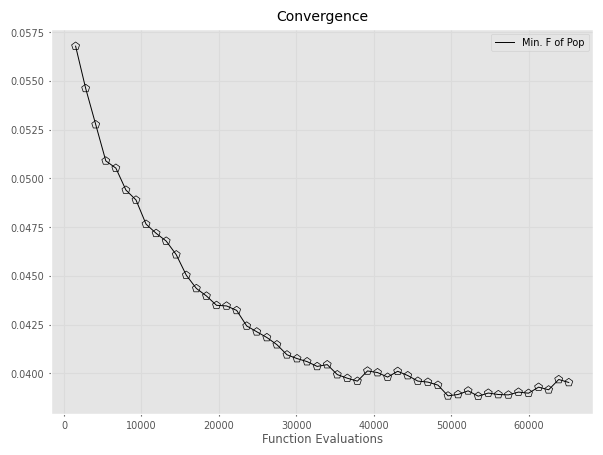

In [60]:
# replace this line by `hist_cv` if you like to analyze the least feasible optimal solution and not the population
vals = hist_l2_avg

# k = np.where(np.array(vals) <= 0.0)[0].min()
# print(f"Whole population feasible in Generation {k} after {n_evals[k]} evaluations.")

plt.figure(figsize=(7, 5))
plt.plot(n_evals, vals,  color='black', lw=0.7, label="Min. F of Pop")
plt.scatter(n_evals, vals,  facecolor="none", edgecolor='black', marker="p")
# plt.axvline(n_evals[k], color="red", label="All Feasible", linestyle="-el="All Feasible", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.legend()
plt.show()